In [59]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import itertools
from os import listdir
import uproot
import awkward as ak
from sklearn.model_selection import train_test_split

import matplotlib as mpl

from datetime import datetime
import subprocess
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model, Sequential
import os
import tensorflow as tf
import sys
import importlib
sys.path.append('/scratch/mjosef/Unfolding/omnifold')
from omnifold import DataLoader, MLP, SetStyle, HistRoutine, net, PET, omnifold
import test_omnifold
from of_transformer import block, embed, input_distributed, net_utils, of_transformer, pair_embed, sequence_trimmer 

from IPython.display import Image

os.environ['CUDA_VISIBLE_DEVICES']="2" #odslserv 0123 überprüfen
has_gpu=True

from pickle import dump

print(tf.config.list_physical_devices())

if has_gpu :
    os.environ['CUDA_VISIBLE_DEVICES']="7"
    physical_devices = tf.config.list_physical_devices('GPU') 
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)

Horovod not found, will continue with single only GPUs.
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
TUnfold_incl_path = '/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/unfolding_SR_Bulk_Final_l_4j_incl_TUnfoldStandalone_OptionA_data_nonClosureAlternative.root'
TUnfold_incl_file = uproot.open(TUnfold_incl_path)

pythia_df = pd.read_pickle('/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/df_pythia_ttbar.pkl')
#herwig_df = pd.read_pickle('/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/df_herwig_ttbar.pkl')
data_df = pd.read_pickle('/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/df_data.pkl')
data_df.fillna(0.0, inplace=True)

In [3]:
def MC_data_shaper(df):

    particle_names = ['l1', 'b1', 'b2', 'b3', 'b4', 'j1', 'j2', 'j3', 'j4', 'j5', 'j6']

    # Build reco and truth arrays
    reco_pts  = [df[f'pt{p}']   for p in particle_names]
    reco_etas = [df[f'eta{p}']  for p in particle_names]
    reco_phis = [df[f'phi{p}']  for p in particle_names]
    
    # Masses: lepton = 0, b-jets = mb1–4, jets = mj1–6
    reco_masses = [np.zeros_like(df['ptl1'])] + \
                  [df[f'mb{i}'] for i in range(1, 5)] + \
                  [df[f'mj{i}'] for i in range(1, 7)]
    # Stack into (12 particles, n_events, 4)
    reco_features = np.stack([reco_pts, reco_etas, reco_phis, reco_masses], axis=-1)
    reco_features = reco_features.transpose(1, 0, 2)  # → (n_events, 12, 4)

    # Neutrino (reco): met, eta=0, phi=metphi, mass=0
    met_pt = df['met']
    met_phi = df['metphi']
    zeros = np.zeros_like(met_pt)
    neutrino_reco = np.stack([met_pt, zeros, met_phi, zeros], axis=-1)  # (n_events, 4)

    # Append neutrino
    reco_features = np.concatenate([reco_features, neutrino_reco[:, None, :]], axis=1)  # (n_events, 12, 4)
    truth_pts  = [df[f'truth_pt{p}']   for p in particle_names]
    truth_etas = [df[f'truth_eta{p}']  for p in particle_names]
    truth_phis = [df[f'truth_phi{p}']  for p in particle_names]
    
    truth_masses = [np.zeros_like(df['truth_ptl1'])] + \
                   [df[f'truth_mb{i}'] for i in range(1, 5)] + \
                   [df[f'truth_mj{i}'] for i in range(1, 7)]

    truth_features = np.stack([truth_pts, truth_etas, truth_phis, truth_masses], axis=-1)
    truth_features = truth_features.transpose(1, 0, 2)

    # Neutrino (truth): use 'truth_met' and 'truth_met_phi'
    truth_met_pt = df['truth_met']
    truth_met_phi = df['truth_metphi']
    zeros_truth = np.zeros_like(truth_met_pt)
    neutrino_truth = np.stack([truth_met_pt, zeros_truth, truth_met_phi, zeros_truth], axis=-1)

    truth_features = np.concatenate([truth_features, neutrino_truth[:, None, :]], axis=1)
    
    return reco_features, truth_features

def DATA_shaper(df):

    particle_names = ['l1', 'b1', 'b2', 'b3', 'b4', 'j1', 'j2', 'j3', 'j4', 'j5', 'j6']

    # Build reco and truth arrays
    reco_pts  = [df[f'pt{p}']   for p in particle_names]
    reco_etas = [df[f'eta{p}']  for p in particle_names]
    reco_phis = [df[f'phi{p}']  for p in particle_names]
    
    # Masses: lepton = 0, b-jets = mb1–4, jets = mj1–6
    reco_masses = [np.zeros_like(df['ptl1'])] + \
                  [df[f'mb{i}'] for i in range(1, 5)] + \
                  [df[f'mj{i}'] for i in range(1, 7)]
    # Stack into (12 particles, n_events, 4)
    reco_features = np.stack([reco_pts, reco_etas, reco_phis, reco_masses], axis=-1)
    reco_features = reco_features.transpose(1, 0, 2)  # → (n_events, 12, 4)

    # Neutrino (reco): met, eta=0, phi=metphi, mass=0
    met_pt = df['met']
    met_phi = df['metphi']
    zeros = np.zeros_like(met_pt)
    neutrino_reco = np.stack([met_pt, zeros, met_phi, zeros], axis=-1)  # (n_events, 4)

    # Append neutrino
    reco_features = np.concatenate([reco_features, neutrino_reco[:, None, :]], axis=1)  # (n_events, 12, 4)
    
    return reco_features

In [4]:
pythia_reco, pythia_truth = MC_data_shaper(pythia_df)
data_array = DATA_shaper(data_df)

pythia_weights = pythia_df['eventWeight'].to_numpy()
data_weights = data_df['eventWeight'].to_numpy()

pythia_pass_reco = pythia_df['pass_reco'].to_numpy()
pythia_pass_gen = pythia_df['pass_particle'].to_numpy()

In [5]:
from sklearn.preprocessing import StandardScaler
import joblib

def prepare_features(X):
    """
    X: array shape (n_events, n_particles, 4)
       columns correspond to (pt, eta, phi, mass)
    returns: scaled features, fitted scalers, and feature description
    """

    # Split into separate variables
    pt   = X[..., 0]
    eta  = X[..., 1]
    phi  = X[..., 2]
    mass = X[..., 3]

    # Handle angular variable properly
    sin_phi = np.sin(phi)
    cos_phi = np.cos(phi)

    # Log-transform positive features
    log_pt   = np.log1p(pt)
    log_mass = np.log1p(mass)

    # Stack back into shape (N, P, F)
    features = np.stack([log_pt, eta, sin_phi, cos_phi, log_mass], axis=-1)
    n_events, n_particles, n_features = features.shape

    # Flatten over (events, particles) for fitting
    flat = features.reshape(-1, n_features)

    # Fit scaler
    scaler = StandardScaler().fit(flat)
    scaled = scaler.transform(flat).reshape(n_events, n_particles, n_features)

    return scaled, scaler, ["log_pt", "eta", "sin_phi", "cos_phi", "log_mass"]

In [6]:
all_indices_pythia = np.arange(len(pythia_reco))
np.random.seed(42)  # reproducibility
np.random.shuffle(all_indices_pythia)

# First random sample
random_indices_pythia_1 = all_indices_pythia[:1_000_000]
# Second, independent (non-overlapping) sample
random_indices_pythia_2 = all_indices_pythia[1_000_000:2_000_000]

# First Pythia sample
pythia_reco_train    = pythia_reco[random_indices_pythia_1]
pythia_truth_train   = pythia_truth[random_indices_pythia_1]
pythia_weights_train = pythia_weights[random_indices_pythia_1]
pythia_pass_reco_train = pythia_pass_reco[random_indices_pythia_1]
pythia_pass_gen_train = pythia_pass_gen[random_indices_pythia_1]

# Second Pythia sample
pythia_reco_test    = pythia_reco[random_indices_pythia_2]
pythia_truth_test   = pythia_truth[random_indices_pythia_2]
pythia_weights_test = pythia_weights[random_indices_pythia_2]
pythia_pass_reco_test = pythia_pass_reco[random_indices_pythia_2]
pythia_pass_gen_test = pythia_pass_gen[random_indices_pythia_2]

In [7]:
pythia_reco.shape, pythia_truth.shape, data_array.shape

((192570169, 12, 4), (192570169, 12, 4), (4301954, 12, 4))

In [9]:
X_reco_scaled, reco_scaler, reco_feature_names = prepare_features(pythia_reco_train)
X_truth_scaled, truth_scaler, truth_feature_names = prepare_features(pythia_truth_train)
data_scaled, data_scaler, data_feature_names = prepare_features(data_array[:1_000_000])

In [28]:
def make_flat(X):
    pt   = X[..., 0]
    eta  = X[..., 1]
    phi  = X[..., 2]
    mass = X[..., 3]

    # Handle angular variable properly
    sin_phi = np.sin(phi)
    cos_phi = np.cos(phi)

    # Log-transform positive features
    log_pt   = np.log1p(pt)
    log_mass = np.log1p(mass)

    # Stack back into shape (N, P, F)
    features = np.stack([log_pt, eta, sin_phi, cos_phi, log_mass], axis=-1)
    n_events, n_particles, n_features = features.shape

    # Flatten over (events, particles) for fitting
    flat = features.reshape(-1, n_features)
    return flat

In [29]:
Y_truth_scaled = truth_scaler.transform(make_flat(pythia_truth_test)).reshape(-1, 12, 5)

In [10]:
X_reco_scaled.shape, X_truth_scaled.shape, data_scaled.shape

((1000000, 12, 5), (1000000, 12, 5), (1000000, 12, 5))

In [11]:
pythia_loader = DataLoader(reco = X_reco_scaled, gen = X_truth_scaled, weight = pythia_weights_train,
                           pass_reco = pythia_pass_reco_train, pass_gen = pythia_pass_gen_train,
                           normalize=True, normalization_factor = np.sum(pythia_weights_train))
testset_loader = DataLoader(reco = pythia_reco_test, gen = pythia_truth_test, weight = pythia_weights_test,
                           pass_reco = pythia_pass_reco_test, pass_gen = pythia_pass_gen_test,
                           normalize=True, normalization_factor = np.sum(pythia_weights_test))
data_loader = DataLoader(reco = data_scaled, weight = data_weights[:1_000_000],
                       normalize=True, normalization_factor = np.sum(data_weights[:1_000_000]))

INFO: Normalizing sum of weights to 58135.8984375 ...
INFO: Normalizing sum of weights to 58223.66015625 ...
INFO: Creating pass reco flag ...
INFO: Normalizing sum of weights to 1000000.0 ...


In [12]:
train_fraction = len(pythia_truth_train)/len(pythia_df)
print("Train fraction:", train_fraction)

Train fraction: 0.005192912304085894


In [14]:
def make_mc_subsample(loader, reco_cuts_mask, N_data):
    """
    Erzeuge ein MC-Subsample mit gleicher statistischer Genauigkeit wie die Daten.

    Parameters
    ----------
    loader : DataLoader
        DataLoader-Objekt mit Attributen `.reco`, `.gen`, `.weight`
    reco_cuts_mask : np.ndarray(bool)
        Maske der Events, die die Reco-Level-Cuts bestehen (analog zu den Daten)
    N_data : int
        Anzahl an Daten-Events, die die Reco-Level-Cuts bestehen
    """

    # Gesamtanzahl an MC-Events
    n_events = len(loader.weight)

    # Init: alle Flags auf False
    flags = np.zeros(n_events, dtype=bool)

    # Summen
    sum_w = 0.0
    sum_w2 = 0.0

    # Ziel-Statistik (Daten haben alle w=1)
    target_rel_unc = 1.0 / np.sqrt(N_data)

    # Loop über Events
    for idx in range(n_events):
        if not reco_cuts_mask[idx]:
            continue

        w = loader.weight[idx]
        sum_w += w
        sum_w2 += w**2

        flags[idx] = True  # Event geht ins Subsample

        # relative Unsicherheit bisher
        rel_unc = np.sqrt(sum_w2) / sum_w

        if rel_unc < target_rel_unc:
            break

    return flags

In [15]:
flags_mc = make_mc_subsample(
    pythia_loader,
    reco_cuts_mask=pythia_loader.pass_reco,
    N_data=np.sum(data_loader.weight)
)

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

class MaskedAveragePooling(layers.Layer):
    def call(self, x, mask):
        # x: (batch, seq_len, features)
        # mask: (batch, seq_len), dtype bool
        mask = tf.cast(mask, tf.float32)[..., tf.newaxis]  # (batch, seq_len, 1)
        x = x * mask
        return tf.reduce_sum(x, axis=1) / tf.reduce_sum(mask, axis=1)

class ParticleMaskLayer(layers.Layer):
    def call(self, x):
        return tf.reduce_any(tf.not_equal(x, 0), axis=-1)  # shape: (batch, seq)

def build_transformer_model(input_shape=(12, 5),
                            num_heads=4,
                            ff_dim=64,
                            num_transformer_blocks=2,
                            dropout_rate=0.1):

    inputs = Input(shape=input_shape)

    # Get attention mask: True where not padded
    mask = ParticleMaskLayer()(inputs)  # shape: (batch, 11)

    # Learned positional embedding
    positions = tf.range(start=0, limit=input_shape[0], delta=1)
    pos_embed = layers.Embedding(input_dim=input_shape[0], output_dim=input_shape[1])(positions)
    x = inputs + pos_embed  # broadcasting position embedding

    for _ in range(num_transformer_blocks):
        attn_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=input_shape[1]
        )(x, x, attention_mask=mask[:, tf.newaxis, :])  # shape: (batch, 1, 11)

        attn_output = layers.Dropout(dropout_rate)(attn_output)
        x = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)

        ff_output = layers.Dense(ff_dim, activation='relu')(x)
        ff_output = layers.Dense(input_shape[1])(ff_output)
        ff_output = layers.Dropout(dropout_rate)(ff_output)
        x = layers.LayerNormalization(epsilon=1e-6)(x + ff_output)

    # Use masked average pooling instead of GlobalAveragePooling1D
    x = MaskedAveragePooling()(x, mask)

    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    return Model(inputs=inputs, outputs=outputs)

In [19]:
model1 = build_transformer_model()
model2 = build_transformer_model()

In [60]:
importlib.reload(test_omnifold)

Horovod not found, will continue with single only GPUs.


<module 'test_omnifold' from '/scratch/mjosef/Unfolding/omnifold/test_omnifold.py'>

In [61]:
omnifold = test_omnifold.MultiFold(
    "WWbb_real-data_scaled",
    model1,
    model2,
    data_loader,
    pythia_loader,
    batch_size = 128,
    niter = 3,  #Number of Iterations                                                                                                                                                                                                  
    epochs=100,     
    weights_folder = '/scratch/mjosef/Unfolding/omnifold/weights_real-data_scaled',
    verbose = True,
    lr = 1e-6,
    early_stop=5,
    n_ensemble=1,
)

15625 training steps at reco and 15625 steps at gen


In [62]:
%%time
omnifold.Unfold()

ITERATION: 1
RUNNING STEP 1
Creating cached data from step 1
################################################################################
Train events used: 2000000, Test events used: 399999
################################################################################
Epoch 1/100
   38/12500 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - loss: 0.2416   

2025-10-16 15:56:57.701424: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_3', 100 bytes spill stores, 96 bytes spill loads



12500/12500 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - loss: 0.2290 - val_loss: 0.2097 - learning_rate: 1.0000e-06
Epoch 2/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 0.2050 - val_loss: 0.1918 - learning_rate: 1.0000e-06
Epoch 3/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 0.1889 - val_loss: 0.1812 - learning_rate: 1.0000e-06
Epoch 4/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 0.1802 - val_loss: 0.1759 - learning_rate: 1.0000e-06
Epoch 5/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 0.1753 - val_loss: 0.1730 - learning_rate: 1.0000e-06
Epoch 6/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 0.1729 - val_loss: 0.1716 - learning_rate: 1.0000e-06
Epoch 7/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 0.1715 - val_loss: 0.1709 - learning_rate: 1.0000e-06
Epoch 8/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 0.1707 - val_loss: 0.1706 - learning_rate: 1.0000e-06
Epoch 9/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms

2025-10-16 16:09:43.289756: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_3', 100 bytes spill stores, 96 bytes spill loads



12500/12500 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step - loss: 0.0446 - val_loss: 0.0447 - learning_rate: 1.0000e-06
Epoch 2/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - loss: 0.0448 - val_loss: 0.0447 - learning_rate: 1.0000e-06
Epoch 3/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - loss: 0.0447 - val_loss: 0.0447 - learning_rate: 1.0000e-06
Epoch 4/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - loss: 0.0447 - val_loss: 0.0447 - learning_rate: 1.0000e-06
Epoch 5/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - loss: 0.0447 - val_loss: 0.0447 - learning_rate: 1.0000e-06
Epoch 6/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - loss: 0.0447 - val_loss: 0.0447 - learning_rate: 1.0000e-06
Epoch 7/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - loss: 0.0447 - val_loss: 0.0447 - learning_rate: 1.0000e-06
Epoch 8/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - loss: 0.0447 - val_loss: 0.0447 - learning_rate: 1.0000e-06
Epoch 9/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms

2025-10-16 16:58:34.418339: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_3', 100 bytes spill stores, 96 bytes spill loads



12500/12500 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 0.1755 - val_loss: 0.1756 - learning_rate: 1.0000e-06
Epoch 2/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 0.1757 - val_loss: 0.1756 - learning_rate: 1.0000e-06
Epoch 3/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 0.1754 - val_loss: 0.1756 - learning_rate: 1.0000e-06
Epoch 4/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 0.1756 - val_loss: 0.1756 - learning_rate: 1.0000e-06
Epoch 5/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - loss: 0.1756 - val_loss: 0.1756 - learning_rate: 1.0000e-06
Epoch 6/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 0.1756 - val_loss: 0.1756 - learning_rate: 1.0000e-06
Last val loss 0.17559696733951569
INFO: Dumping training history ...
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 982us/step
RUNNING STEP 2
################################################################################
Train events used: 2000000, Test events used: 399999
#############################

2025-10-16 17:01:45.419669: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_3', 100 bytes spill stores, 96 bytes spill loads



12500/12500 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 0.0548 - val_loss: 0.0544 - learning_rate: 1.0000e-06
Epoch 2/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 0.0544 - val_loss: 0.0539 - learning_rate: 1.0000e-06
Epoch 3/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 0.0540 - val_loss: 0.0537 - learning_rate: 1.0000e-06
Epoch 4/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 0.0537 - val_loss: 0.0536 - learning_rate: 1.0000e-06
Epoch 5/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 0.0536 - val_loss: 0.0535 - learning_rate: 1.0000e-06
Epoch 6/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 0.0534 - val_loss: 0.0535 - learning_rate: 1.0000e-06
Epoch 7/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 0.0535 - val_loss: 0.0535 - learning_rate: 1.0000e-06
Epoch 8/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 0.0534 - val_loss: 0.0535 - learning_rate: 1.0000e-06
Epoch 9/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms

2025-10-16 17:50:53.141816: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_3', 100 bytes spill stores, 96 bytes spill loads



12500/12500 ━━━━━━━━━━━━━━━━━━━━ 46s 3ms/step - loss: 0.1839 - val_loss: 0.1836 - learning_rate: 1.0000e-06
Epoch 2/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - loss: 0.1837 - val_loss: 0.1836 - learning_rate: 1.0000e-06
Epoch 3/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - loss: 0.1838 - val_loss: 0.1836 - learning_rate: 1.0000e-06
Epoch 4/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 0.1839 - val_loss: 0.1836 - learning_rate: 1.0000e-06
Epoch 5/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - loss: 0.1839 - val_loss: 0.1836 - learning_rate: 1.0000e-06
Epoch 6/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - loss: 0.1836 - val_loss: 0.1836 - learning_rate: 1.0000e-06
Last val loss 0.18363988399505615
INFO: Dumping training history ...
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
RUNNING STEP 2
################################################################################
Train events used: 2000000, Test events used: 399999
###############################

2025-10-16 17:54:19.160767: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_3', 100 bytes spill stores, 96 bytes spill loads



12500/12500 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - loss: 0.0644 - val_loss: 0.0639 - learning_rate: 1.0000e-06
Epoch 2/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - loss: 0.0640 - val_loss: 0.0637 - learning_rate: 1.0000e-06
Epoch 3/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 0.0638 - val_loss: 0.0637 - learning_rate: 1.0000e-06
Epoch 4/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - loss: 0.0637 - val_loss: 0.0636 - learning_rate: 1.0000e-06
Epoch 5/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - loss: 0.0635 - val_loss: 0.0636 - learning_rate: 1.0000e-06
Epoch 6/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - loss: 0.0636 - val_loss: 0.0636 - learning_rate: 1.0000e-06
Epoch 7/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - loss: 0.0636 - val_loss: 0.0636 - learning_rate: 1.0000e-06
Epoch 8/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - loss: 0.0635 - val_loss: 0.0635 - learning_rate: 1.0000e-06
Epoch 9/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms

In [63]:
unfolded_weights  = omnifold.reweight(Y_truth_scaled,omnifold.model2,batch_size=1000)

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step  


In [67]:
np.save("/scratch/mjosef/Unfolding/omnifold/weights_real-data_scaled/unfolded_weights.npy", unfolded_weights)

In [ ]:
unfolded_weights = np.load("/scratch/mjosef/Unfolding/omnifold/weights_real-data_scaled/unfolded_weights.npy")

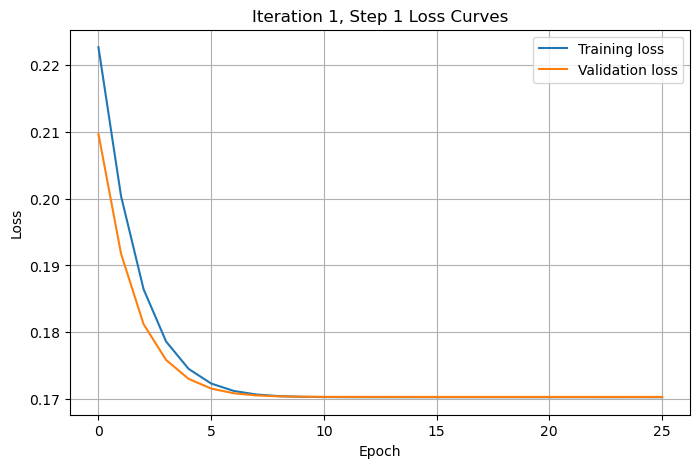

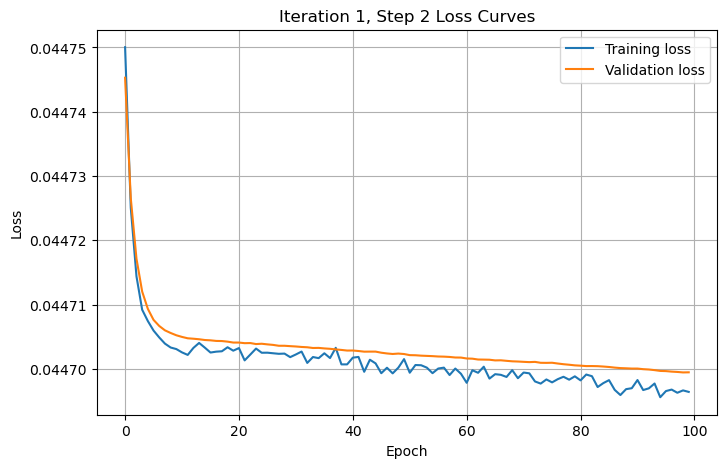

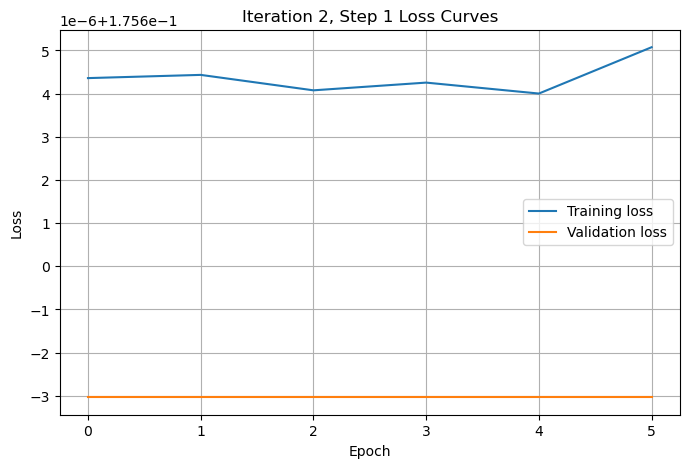

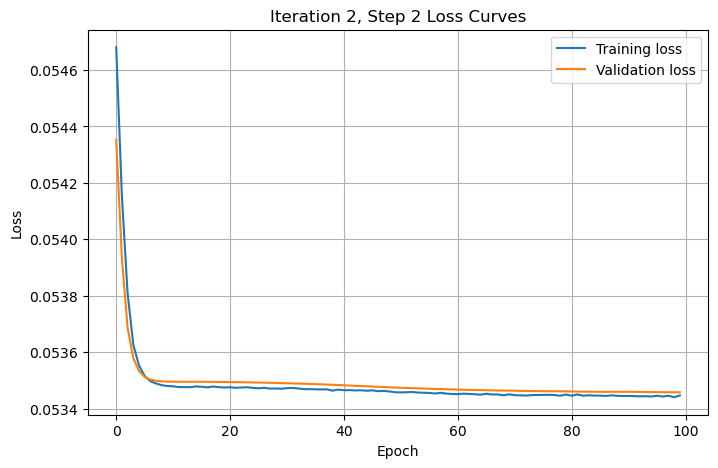

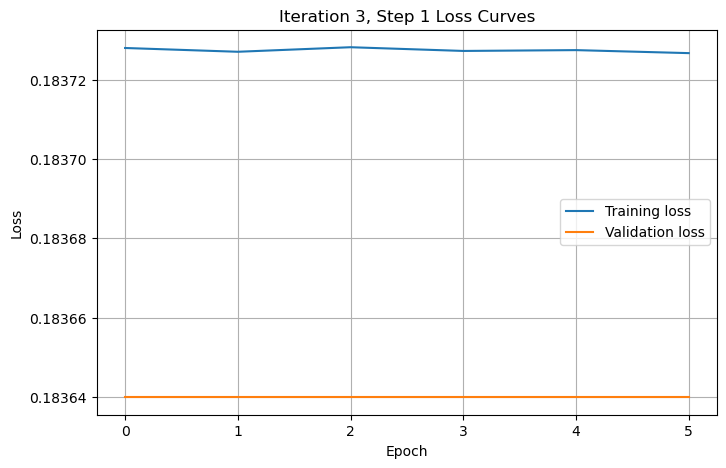

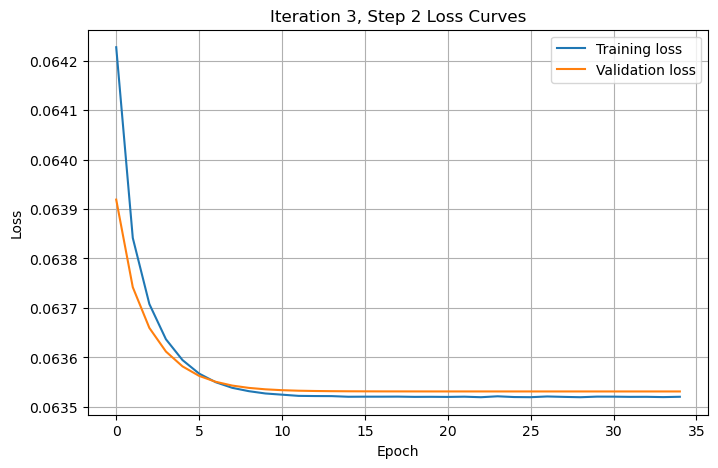

In [64]:
import pickle
import os
# Set these to your parameters
weights_folder = '/scratch/mjosef/Unfolding/omnifold/weights_real-data_scaled'      
name = "WWbb_real-data_scaled"     
niter = 3                       
n_ensemble = 1                  
# Loop over iterations and steps
for iteration in range(niter):
    for stepn in [1, 2]:
        plt.figure(figsize=(8,5))
        plt.title(f"Iteration {iteration+1}, Step {stepn} Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        
        all_loss = []
        all_val_loss = []

        for e in range(n_ensemble):
            # Construct pickle file name
            model_file = f"{weights_folder}/OmniFold_{name}_iter{iteration}_step{stepn}"
            if n_ensemble > 1:
                model_file += f"_ensemble{e}"
            model_file += ".weights.h5"
            history_file = model_file.replace(".weights.h5", ".pkl")
            
            # Load history
            if os.path.exists(history_file):
                with open(history_file, "rb") as f:
                    history = pickle.load(f)
                all_loss.append(history['loss'])
                all_val_loss.append(history['val_loss'])
            else:
                print(f"History file not found: {history_file}")

        # Average over ensembles if multiple
        avg_loss = np.mean(all_loss, axis=0)
        avg_val_loss = np.mean(all_val_loss, axis=0)

        plt.plot(avg_loss, label='Training loss')
        plt.plot(avg_val_loss, label='Validation loss')
        plt.legend()
        plt.grid(True)
        plt.show()


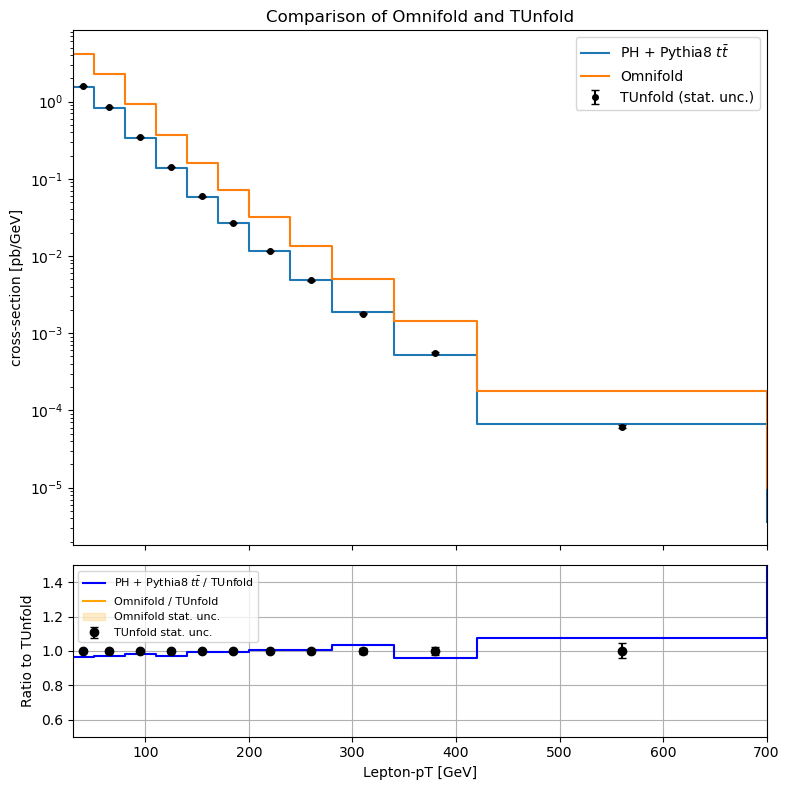

In [65]:
hist = TUnfold_incl_file['unfolding_ptl1_NOSYS']
rel_ptl1_up = TUnfold_incl_file['unfolding_error_ptl1_direct_STAT_DATA__1up;1']
rel_ptl1_down = TUnfold_incl_file['unfolding_error_ptl1_direct_STAT_DATA__1down;1']
values = hist.values()
edges = hist.axis().edges()

luminosity = 3244.54 + 33402.2 + 44630.6 + 58791.6
SF = (1/luminosity)*1/train_fraction
bin_widths = np.diff(edges)

rel_unc_up_tunfold = rel_ptl1_up.values()
rel_unc_down_tunfold = rel_ptl1_down.values()

weights_omnifold = (unfolded_weights * testset_loader.weight)[testset_loader.pass_gen & flags_mc] * SF
weights_omnifold2 = weights_omnifold**2
values_omnifold = testset_loader.gen[:,0,0][testset_loader.pass_gen & flags_mc]

# Histogram Omnifold
counts2, _ = np.histogram(values_omnifold, bins=edges, weights=weights_omnifold)
counts2_density = counts2 / bin_widths

# relative Unsicherheit pro Bin für Omnifold
sum_w2, _ = np.histogram(values_omnifold, bins=edges, weights=weights_omnifold2)
counts2 = counts2.astype(float)
sum_w2 = sum_w2.astype(float)

with np.errstate(divide='ignore', invalid='ignore'):
    rel_unc_omnifold = np.sqrt(sum_w2) / counts2
    rel_unc_omnifold[~np.isfinite(rel_unc_omnifold)] = 0

fig, (ax1, ax2) = plt.subplots(
    2, 1, 
    figsize=(8, 8), 
    gridspec_kw={'height_ratios': [3, 1]}, 
    sharex=True
)


# --- Upper panel: your histograms ---
counts1, bins1, _ = ax1.hist(
    pythia_truth_test[:,0,0], 
    weights=pythia_weights_test*pythia_pass_gen_test*SF, 
    bins=edges, 
    histtype='step', 
    label='Pythia ttbar'
)
counts2, bins2, _ = ax1.hist(
    testset_loader.gen[:, 0, 0][testset_loader.pass_gen], 
    weights=(unfolded_weights * testset_loader.weight)[testset_loader.pass_gen] * SF, 
    bins=edges, 
    histtype='step', 
    label='Omnifold'
)

bin_centers = 0.5 * (edges[:-1] + edges[1:])
# Normalize counts by bin width
counts1_density = counts1 / bin_widths
counts2_density = counts2 / bin_widths
values_density = values / bin_widths
abs_unc_up_tunfold = rel_unc_up_tunfold * values_density
abs_unc_down_tunfold = rel_unc_down_tunfold * values_density


# Re-plot them stepwise
ax1.cla()
ax1.step(edges[:-1], counts1_density, where="post", label=r"PH + Pythia8 $t\bar{t}$")
ax1.step(edges[:-1], counts2_density, where="post", label="Omnifold")

yerr = np.vstack((abs_unc_down_tunfold, abs_unc_up_tunfold))
ax1.errorbar(
    bin_centers[:-1], values_density[:-1],
    yerr=yerr[:,:-1],
    fmt='o', color='black', capsize=3, markersize=4,
    label="TUnfold (stat. unc.)"
)
#ax1.plot(bin_centers[:-1], values_density[:-1], 'o', color='black', label='TUnfold')

ax1.set_ylabel("cross-section [pb/GeV]")
ax1.set_title("Comparison of Omnifold and TUnfold")
ax1.legend()
ax1.set_yscale('log')

# --- Lower panel: ratio ---
# Avoid division by zero
ratio1 = np.divide(counts1_density, values_density, out=np.zeros_like(counts1_density), where=values_density!=0)
ratio2 = np.divide(counts2_density, values_density, out=np.zeros_like(counts2_density), where=values_density!=0)
ratio3 = np.ones_like(values_density)  # TUnfold / TUnfold

# Step style ratios
ratio1_step = np.append(ratio1, ratio1[-1])
ratio2_step = np.append(ratio2, ratio2[-1])

upper_omnifold = ratio2 * (1 + rel_unc_omnifold)
lower_omnifold = ratio2 * (1 - rel_unc_omnifold)

upper_tunfold = ratio3 * (1 + rel_unc_up_tunfold)
lower_tunfold = ratio3 * (1 - rel_unc_down_tunfold)

err_up_tunfold = ratio3 * rel_ptl1_up.values()
err_down_tunfold = ratio3 * rel_ptl1_down.values()
yerr_tunfold = np.vstack((err_down_tunfold, err_up_tunfold))
ax2.step(edges[:-1], ratio1_step[:-1], where="post", color="blue", label=r"PH + Pythia8 $t\bar{t}$ / TUnfold")
ax2.step(edges[:-1], ratio2_step[:-1], where="post", color="orange", label="Omnifold / TUnfold")
#ax2.plot(bin_centers[:-1], ratio3[:-1], 'o', color='black', label='TUnfold')
ax2.errorbar(
    bin_centers[:-1], ratio3[:-1],
    yerr=yerr_tunfold[:,:-1],
    fmt='o', color='black', capsize=3, label='TUnfold stat. unc.'
)
#ax2.fill_between(edges[:-1], lower_tunfold, upper_tunfold, step='post', alpha=0.3, color='grey', label='TUnfold stat. unc.')
ax2.fill_between(
    edges[:-1],
    lower_omnifold,
    upper_omnifold,
    step='post',
    alpha=0.2,
    color='orange',
    label='Omnifold stat. unc.'
)
#ax2.axhline(1.0, color='red', linestyle='--')

ax2.set_xlabel("Lepton-pT [GeV]")
ax2.set_ylabel("Ratio to TUnfold")
ax2.set_xlim(30, 700)
ax2.set_ylim(0.5, 1.5)
ax2.legend(fontsize=8)
ax2.grid()

plt.tight_layout()
plt.show()

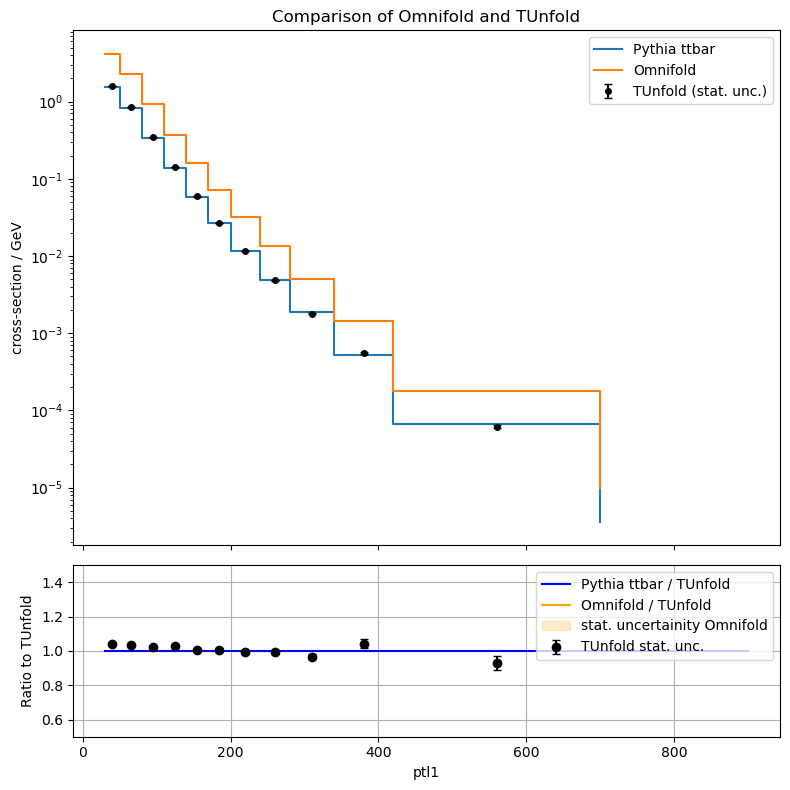

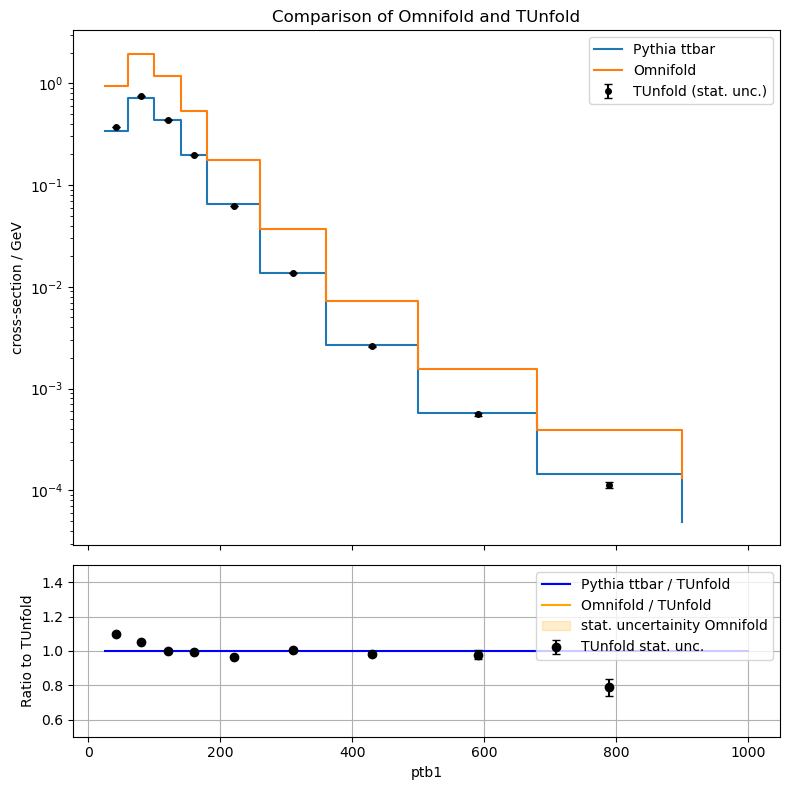

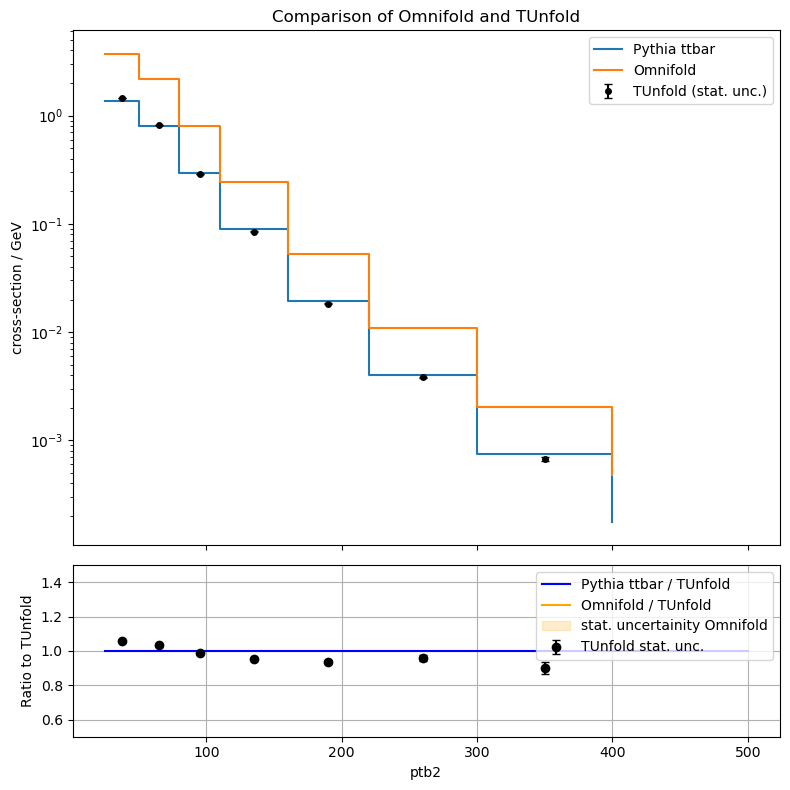

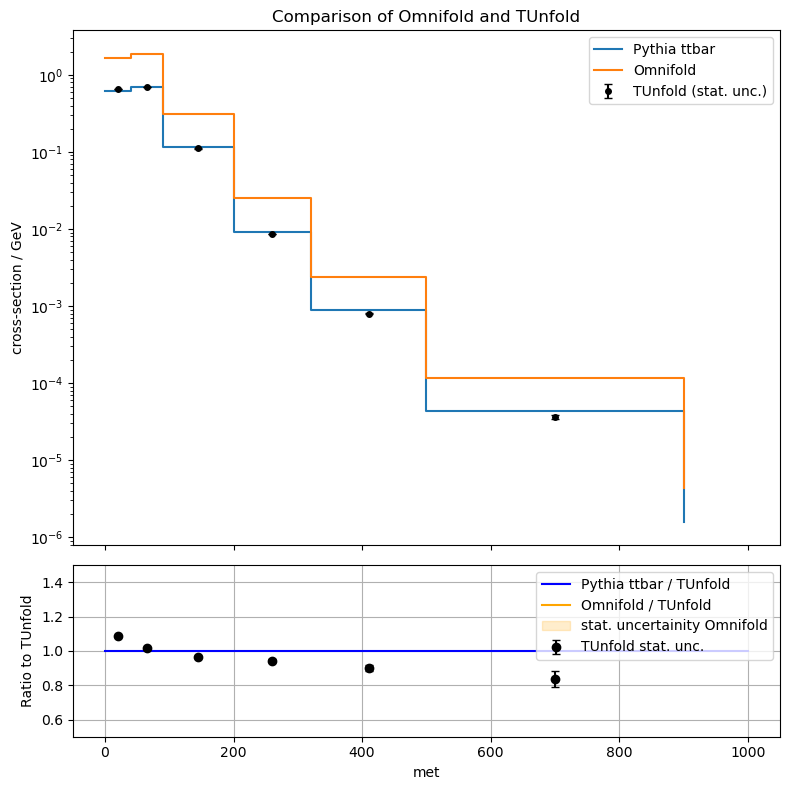

In [66]:
luminosity = 3244.54 + 33402.2 + 44630.6 + 58791.6
SF = (1/luminosity)*1/train_fraction

# -------------------------------
# Loop over all observables
# -------------------------------
observables = {
    "ptl1": 0,  # lepton pt
    "ptb1": 1,
    "ptb2": 2,
    #"ptb3": 3,
    #"ptb4": 4,
    #"ptj1": 5,
    #"ptj2": 6,
    #"ptj3": 7,
    #"ptj4": 8,
    #"ptj5": 9,
    #"ptj6": 10,
    "met":  11,
}
for obs_name, obs_index in observables.items():

    hist = TUnfold_incl_file[f'unfolding_{obs_name}_NOSYS']
    rel_pt_up = TUnfold_incl_file[f'unfolding_error_{obs_name}_direct_STAT_DATA__1up;1']
    rel_pt_down = TUnfold_incl_file[f'unfolding_error_{obs_name}_direct_STAT_DATA__1down;1']
    values = hist.values()
    edges = hist.axis().edges()
    bin_widths = np.diff(edges)
    bin_centers = 0.5 * (edges[:-1] + edges[1:])

    rel_unc_up_tunfold = rel_pt_up.values()
    rel_unc_down_tunfold = rel_pt_down.values()

    weights_omnifold = (unfolded_weights * testset_loader.weight)[testset_loader.pass_gen & flags_mc] * SF
    weights_omnifold2 = weights_omnifold**2
    values_omnifold = testset_loader.gen[:,obs_index,0][testset_loader.pass_gen & flags_mc]

    # Histogram Omnifold
    counts2, _ = np.histogram(values_omnifold, bins=edges, weights=weights_omnifold)
    counts2_density = counts2 / bin_widths

    # relative Unsicherheit pro Bin für Omnifold
    sum_w2, _ = np.histogram(values_omnifold, bins=edges, weights=weights_omnifold2)
    counts2 = counts2.astype(float)
    sum_w2 = sum_w2.astype(float)

    with np.errstate(divide='ignore', invalid='ignore'):
        rel_unc_omnifold = np.sqrt(sum_w2) / counts2
        rel_unc_omnifold[~np.isfinite(rel_unc_omnifold)] = 0

    fig, (ax1, ax2) = plt.subplots(
        2, 1, 
        figsize=(8, 8), 
        gridspec_kw={'height_ratios': [3, 1]}, 
        sharex=True
    )

   # --- Upper panel: your histograms ---
    counts1, bins1, _ = ax1.hist(
        pythia_truth_test[:,obs_index,0], 
        weights=pythia_weights_test*pythia_pass_gen_test*SF, 
        bins=edges, 
        histtype='step', 
        label='Pythia ttbar'
    )
    counts2, bins2, _ = ax1.hist(
        testset_loader.gen[:, obs_index, 0][testset_loader.pass_gen], 
        weights=(unfolded_weights * testset_loader.weight)[testset_loader.pass_gen] * SF, 
        bins=edges, 
        histtype='step', 
        label='Omnifold'
    )
    bin_centers = 0.5 * (edges[:-1] + edges[1:])
    # Normalize counts by bin width
    counts1_density = counts1 / bin_widths
    counts2_density = counts2 / bin_widths
    values_density = values / bin_widths
    abs_unc_up_tunfold = rel_unc_up_tunfold * values_density
    abs_unc_down_tunfold = rel_unc_down_tunfold * values_density

    # Re-plot them stepwise
    ax1.cla()
    ax1.step(edges[:-1], counts1_density, where="post", label="Pythia ttbar")
    ax1.step(edges[:-1], counts2_density, where="post", label="Omnifold")
    yerr = np.vstack((abs_unc_down_tunfold, abs_unc_up_tunfold))
    ax1.errorbar(
        bin_centers[:-1], values_density[:-1],
        yerr=yerr[:,:-1],
        fmt='o', color='black', capsize=3, markersize=4,
        label="TUnfold (stat. unc.)"
    )

    ax1.set_ylabel("cross-section / GeV")
    ax1.set_title("Comparison of Omnifold and TUnfold")
    ax1.set_yscale('log')
    ax1.legend()

    # --- Lower panel: ratio ---
    # Avoid division by zero
    ratio1 = np.divide(values_density, counts1_density, out=np.zeros_like(values_density), where=counts1_density!=0)
    ratio2 = np.divide(counts2_density, counts1_density, out=np.zeros_like(counts2_density), where=counts1_density!=0)
    ratio3 = np.ones_like(counts1_density)  # TUnfold / TUnfold

    # Step style ratios
    ratio1_step = np.append(ratio1, ratio1[-1])
    ratio2_step = np.append(ratio2, ratio2[-1])
    ratio3_step = np.append(ratio3, ratio3[-1])

    upper_omnifold = ratio2 * (1 + rel_unc_omnifold)
    lower_omnifold = ratio2 * (1 - rel_unc_omnifold)

    upper_tunfold = ratio1 * (1 + rel_unc_up_tunfold)
    lower_tunfold = ratio1 * (1 - rel_unc_down_tunfold)

    err_up_tunfold = ratio1 * rel_pt_up.values()
    err_down_tunfold = ratio1 * rel_pt_down.values()
    yerr_tunfold = np.vstack((err_down_tunfold, err_up_tunfold))

    ax2.step(edges, ratio3_step, where="post", color="blue", label="Pythia ttbar / TUnfold")
    ax2.step(edges, ratio2_step, where="post", color="orange", label="Omnifold / TUnfold")
    ax2.errorbar(
            bin_centers[:-1], ratio1[:-1],
            yerr=yerr_tunfold[:,:-1],
            fmt='o', color='black', capsize=3, label='TUnfold stat. unc.'
    )
    ax2.fill_between(
        edges[:-1],
        lower_omnifold,
        upper_omnifold,
        step='post',
        alpha=0.2,
        color='orange',
        label='stat. uncertainity Omnifold'
    )
    #ax2.axhline(1.0, color='red', linestyle='--')

    ax2.set_xlabel(obs_name)
    ax2.set_ylabel("Ratio to TUnfold")
    ax2.set_ylim(0.5, 1.5)
    ax2.legend()
    ax2.grid()

    plt.tight_layout()
    plt.show()

In [41]:
def convert_to4vector(array):
    """
    Convert an array of shape (n_events, n_particles, 4) with (pt, eta, phi, m)
    to an array of shape (n_events, n_particles, 4) with (E, px, py, pz).
    """
    pt = array[:, 0]
    eta = array[:, 1]
    phi = array[:, 2]
    m = array[:, 3]

    px = pt * np.cos(phi)
    py = pt * np.sin(phi)
    pz = pt * np.sinh(eta)
    E = np.sqrt(px**2 + py**2 + pz**2 + m**2)

    return np.stack((E, px, py, pz), axis=-1)

def calculate_mass(array):
    """
    Calculate the invariant mass of the system represented by the input array.
    The input array should have shape (n_events, n_particles, 4) with (E, px, py, pz).
    Returns an array of shape (n_events,) with the invariant mass for each event.
    """
    E = array[:, 0]
    px = array[:, 1]
    py = array[:, 2]
    pz = array[:, 3]

    mass_squared = E**2 - (px**2 + py**2 + pz**2)
    mass_squared = np.maximum(mass_squared, 0)  # Avoid negative values due to numerical issues
    return np.sqrt(mass_squared)

def W_candidate(array):
    # Hard coded W mass
    W_mass = 80.379

    # leading and subleading jets (indices 5 and 6)
    leading_jet = array[:, 5, :]
    subleading_jet = array[:, 6, :]
    leading_jet_4vec = convert_to4vector(leading_jet)
    subleading_jet_4vec = convert_to4vector(subleading_jet)
    combined_4vec = leading_jet_4vec + subleading_jet_4vec

    # Calculate masses
    mass_leading = calculate_mass(leading_jet_4vec)
    mass_subleading = calculate_mass(subleading_jet_4vec)
    mass_combined = calculate_mass(combined_4vec)

    # Stack all masses and 4-vectors: shape (n_events, 3)
    all_masses = np.stack([mass_leading, mass_subleading, mass_combined], axis=1)
    all_4vecs = np.stack([leading_jet_4vec, subleading_jet_4vec, combined_4vec], axis=1)

    # Find index of mass closest to W_mass for each event
    idx_closest = np.argmin(np.abs(all_masses - W_mass), axis=1)

    # Select 4-vector for each event
    selected_4vec = all_4vecs[np.arange(len(array)), idx_closest, :]

    return selected_4vec

def min_mbl(array):
    # b-jet indices: 1, 2
    b_jets = [array[:, i, :] for i in range(1,3)]
    lepton = array[:, 0, :]

    b_jet_4vecs = [convert_to4vector(b_jet) for b_jet in b_jets]
    lepton_4vec = convert_to4vector(lepton)

    mbl_values = []
    for b_jet_4vec in b_jet_4vecs:
        combined_4vec = b_jet_4vec + lepton_4vec
        mbl = calculate_mass(combined_4vec)
        mbl_values.append(mbl)

    mbl_stack = np.stack(mbl_values, axis=1)  # shape (n_events, 2)
    return np.min(mbl_stack, axis=1)  # shape (n_events,)

def min_mbW(array):
    # b-jet indices: 1, 2
    b_jet1 = array[:, 1, :]
    b_jet2 = array[:, 2, :]

    b_jet1_4vec = convert_to4vector(b_jet1)
    b_jet2_4vec = convert_to4vector(b_jet2)

    W_4vec = W_candidate(array)

    combined1_4vec = b_jet1_4vec + W_4vec
    combined2_4vec = b_jet2_4vec + W_4vec

    mbW1 = calculate_mass(combined1_4vec)
    mbW2 = calculate_mass(combined2_4vec)

    mbW_stack = np.stack([mbW1, mbW2], axis=1)  # shape (n_events, 2)
    return np.min(mbW_stack, axis=1)  # shape (n_events,)


def mbb(array):
    # b-jet indices: 1, 2
    b_jet1 = array[:, 1, :]
    b_jet2 = array[:, 2, :]

    b_jet1_4vec = convert_to4vector(b_jet1)
    b_jet2_4vec = convert_to4vector(b_jet2)

    combined_4vec = b_jet1_4vec + b_jet2_4vec
    return calculate_mass(combined_4vec)

def dR2b(array):
    # b-jet indices: 1, 2
    b_jet1 = array[:, 1, :]
    b_jet2 = array[:, 2, :]

    eta1 = b_jet1[:, 1]
    phi1 = b_jet1[:, 2]
    eta2 = b_jet2[:, 1]
    phi2 = b_jet2[:, 2]

    delta_eta = eta1 - eta2
    delta_phi = np.abs(phi1 - phi2)
    delta_phi = np.where(delta_phi > np.pi, 2 * np.pi - delta_phi, delta_phi)

    return np.sqrt(delta_eta**2 + delta_phi**2)

In [53]:
W_candidate(pythia_truth_test).shape

(1000000, 4)

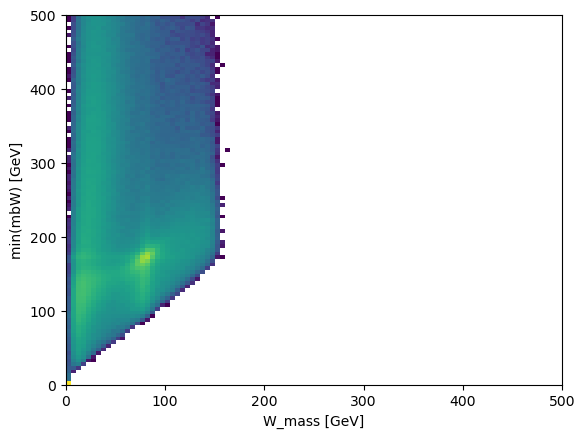

In [68]:
plt.hist2d(((calculate_mass(W_candidate(pythia_truth_test))*pythia_pass_gen_test)), min_mbW(pythia_truth_test)*pythia_pass_gen_test, bins=100, range=[[0,500],[0,500]], norm=LogNorm())
plt.xlabel("W_mass [GeV]")
plt.ylabel("min(mbW) [GeV]")
plt.show()

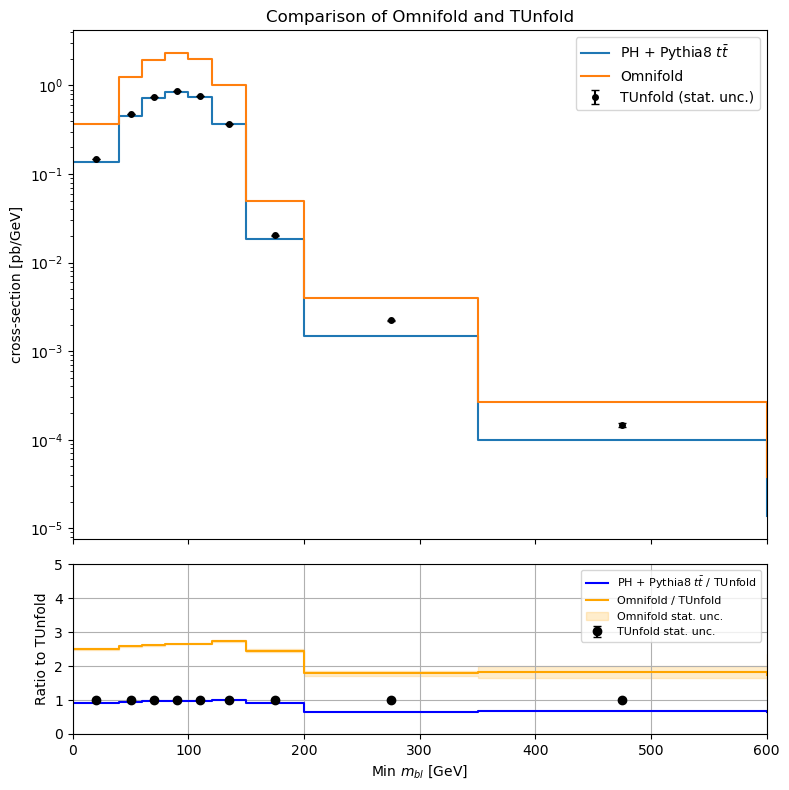

In [71]:
hist = TUnfold_incl_file['unfolding_mblmin_NOSYS']
rel_ptl1_up = TUnfold_incl_file['unfolding_error_mblmin_direct_STAT_DATA__1up;1']
rel_ptl1_down = TUnfold_incl_file['unfolding_error_mblmin_direct_STAT_DATA__1down;1']
values = hist.values()
edges = hist.axis().edges()

luminosity = 3244.54 + 33402.2 + 44630.6 + 58791.6
SF = (1/luminosity)*1/train_fraction
bin_widths = np.diff(edges)

rel_unc_up_tunfold = rel_ptl1_up.values()
rel_unc_down_tunfold = rel_ptl1_down.values()

weights_omnifold = (unfolded_weights * testset_loader.weight)[testset_loader.pass_gen & flags_mc] * SF
weights_omnifold2 = weights_omnifold**2
values_omnifold = min_mbl(testset_loader.gen[testset_loader.pass_gen & flags_mc])

# Histogram Omnifold
counts2, _ = np.histogram(values_omnifold, bins=edges, weights=weights_omnifold)
counts2_density = counts2 / bin_widths

# relative Unsicherheit pro Bin für Omnifold
sum_w2, _ = np.histogram(values_omnifold, bins=edges, weights=weights_omnifold2)
counts2 = counts2.astype(float)
sum_w2 = sum_w2.astype(float)

with np.errstate(divide='ignore', invalid='ignore'):
    rel_unc_omnifold = np.sqrt(sum_w2) / counts2
    rel_unc_omnifold[~np.isfinite(rel_unc_omnifold)] = 0

fig, (ax1, ax2) = plt.subplots(
    2, 1, 
    figsize=(8, 8), 
    gridspec_kw={'height_ratios': [3, 1]}, 
    sharex=True
)



# --- Upper panel: your histograms ---
counts1, bins1, _ = ax1.hist(
    min_mbl(pythia_truth_test), 
    weights=pythia_weights_test*pythia_pass_gen_test*SF, 
    bins=edges, 
    histtype='step', 
    label='Pythia ttbar'
)
counts2, bins2, _ = ax1.hist(
    min_mbl(testset_loader.gen[testset_loader.pass_gen]), 
    weights=(unfolded_weights * testset_loader.weight)[testset_loader.pass_gen] * SF, 
    bins=edges, 
    histtype='step', 
    label='Omnifold'
)
bin_centers = 0.5 * (edges[:-1] + edges[1:])
# Normalize counts by bin width
counts1_density = counts1 / bin_widths
counts2_density = counts2 / bin_widths
values_density = values / bin_widths
abs_unc_up_tunfold = rel_unc_up_tunfold * values_density
abs_unc_down_tunfold = rel_unc_down_tunfold * values_density


# Re-plot them stepwise
ax1.cla()
ax1.step(edges[:-1], counts1_density, where="post", label=r"PH + Pythia8 $t\bar{t}$")
ax1.step(edges[:-1], counts2_density, where="post", label="Omnifold")

yerr = np.vstack((abs_unc_down_tunfold, abs_unc_up_tunfold))
ax1.errorbar(
    bin_centers[:-1], values_density[:-1],
    yerr=yerr[:,:-1],
    fmt='o', color='black', capsize=3, markersize=4,
    label="TUnfold (stat. unc.)"
)

ax1.set_ylabel("cross-section [pb/GeV]")
ax1.set_title("Comparison of Omnifold and TUnfold")
ax1.legend()
ax1.set_yscale('log')

# --- Lower panel: ratio ---
# Avoid division by zero
ratio1 = np.divide(counts1_density, values_density, out=np.zeros_like(counts1_density), where=values_density!=0)
ratio2 = np.divide(counts2_density, values_density, out=np.zeros_like(counts2_density), where=values_density!=0)
ratio3 = np.ones_like(values_density)  # TUnfold / TUnfold

# Step style ratios
ratio1_step = np.append(ratio1, ratio1[-1])
ratio2_step = np.append(ratio2, ratio2[-1])

upper_omnifold = ratio2 * (1 + rel_unc_omnifold)
lower_omnifold = ratio2 * (1 - rel_unc_omnifold)

upper_tunfold = ratio3 * (1 + rel_unc_up_tunfold)
lower_tunfold = ratio3 * (1 - rel_unc_down_tunfold)

err_up_tunfold = ratio3 * rel_ptl1_up.values()
err_down_tunfold = ratio3 * rel_ptl1_down.values()
yerr_tunfold = np.vstack((err_down_tunfold, err_up_tunfold))
ax2.step(edges[:-1], ratio1_step[:-1], where="post", color="blue", label=r"PH + Pythia8 $t\bar{t}$ / TUnfold")
ax2.step(edges[:-1], ratio2_step[:-1], where="post", color="orange", label="Omnifold / TUnfold")
ax2.errorbar(
    bin_centers[:-1], ratio3[:-1],
    yerr=yerr_tunfold[:,:-1],
    fmt='o', color='black', capsize=3, label='TUnfold stat. unc.'
)
ax2.fill_between(
    edges[:-1],
    lower_omnifold,
    upper_omnifold,
    step='post',
    alpha=0.2,
    color='orange',
    label='Omnifold stat. unc.'
)

ax2.set_xlabel(r"Min $m_{bl}$ [GeV]")
ax2.set_ylabel("Ratio to TUnfold")
ax2.set_xlim(0, 600)
ax2.set_ylim(0, 5)
ax2.legend(fontsize=8)
ax2.grid()

plt.tight_layout()
plt.show()